Overarching description...

In [1]:
import pickle

import sys
sys.path.append('../..')

In [2]:
import csv
import pickle
import sys
sys.path.append('../..')

from scipy.interpolate import interp1d

In [24]:
import darkhistory.physics as phys
from config import load_data
import main

import darkhistory.electrons.elec_cooling as elec_cooling
from   darkhistory.spec.spectools import EnglossRebinData
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf

from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.spec.spectools as spectools
import darkhistory.low_energy.lowE_electrons as lowE_elec
import darkhistory.utilities as utils

import darkhistory.low_energy.atomic as atomic

import darkhistory.history.tla as tla

# 1. $f_c(z)$ Old vs. New

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [9]:
pri = 'elec'
DM_process = 'swave'

log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

if pri=='elec':
    if DM_process=='decay':
        mDM_list = 2*(10**log10eng + phys.me)
        
    else:
        mDM_list = 10**log10eng + phys.me

elif pri=='phot':
    if DM_process=='decay':
        mDM_list = 2*10**log10eng
    else:
        mDM_list = 10**log10eng

fs_data = pickle.load(open(
    '/Users/gregoryridgway/Desktop/Data'+
    '/data_fs_'+pri+'_'+DM_process+'.dat', 'rb'))

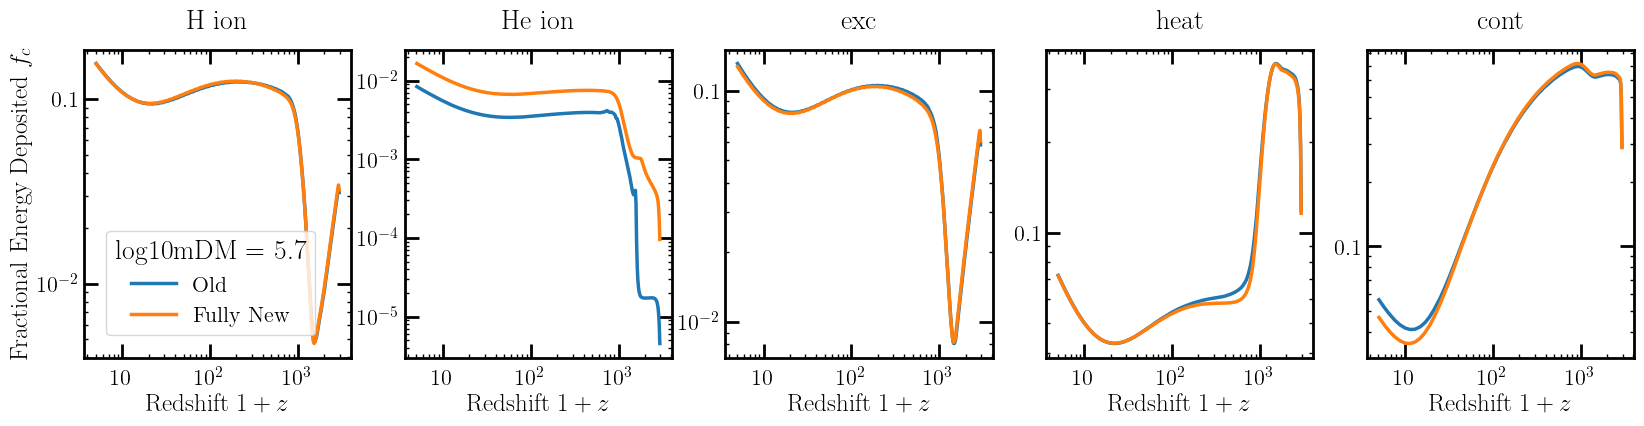

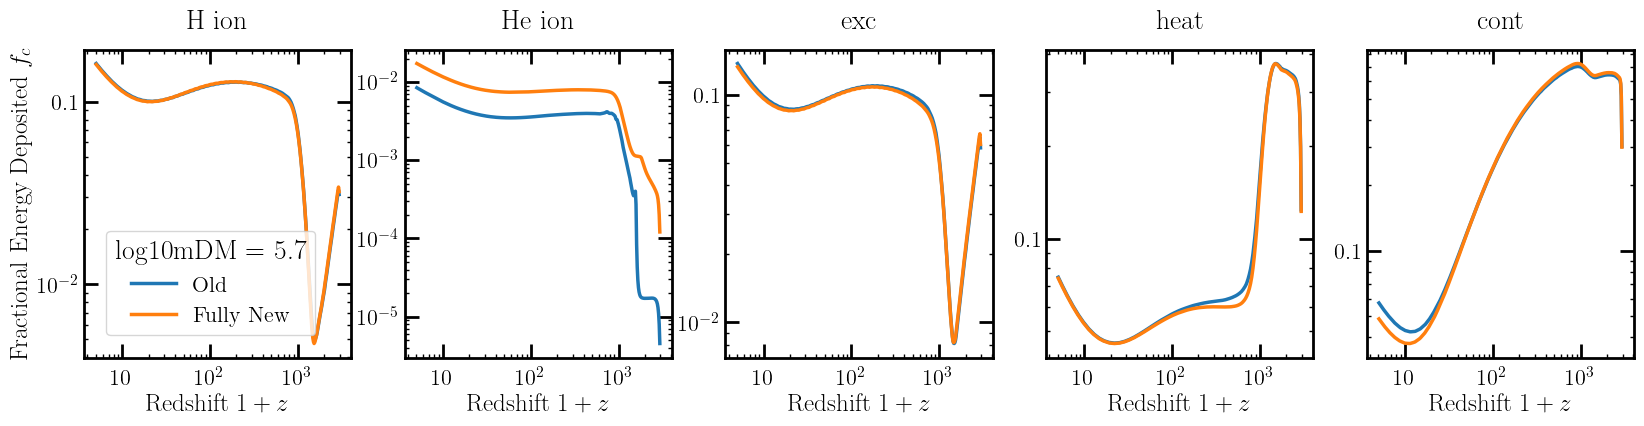

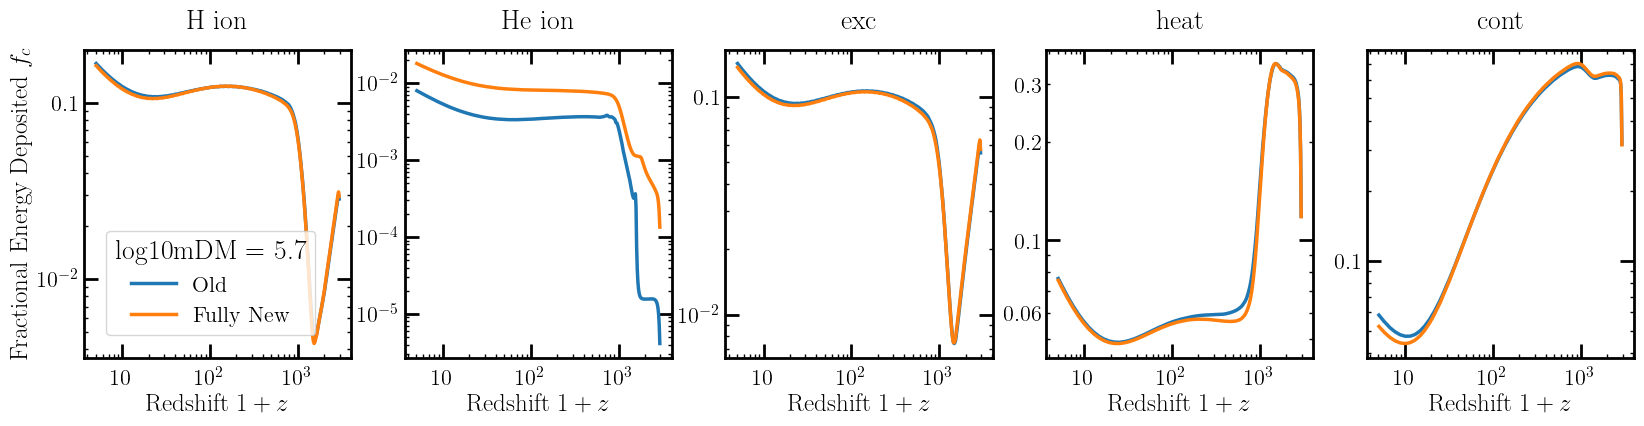

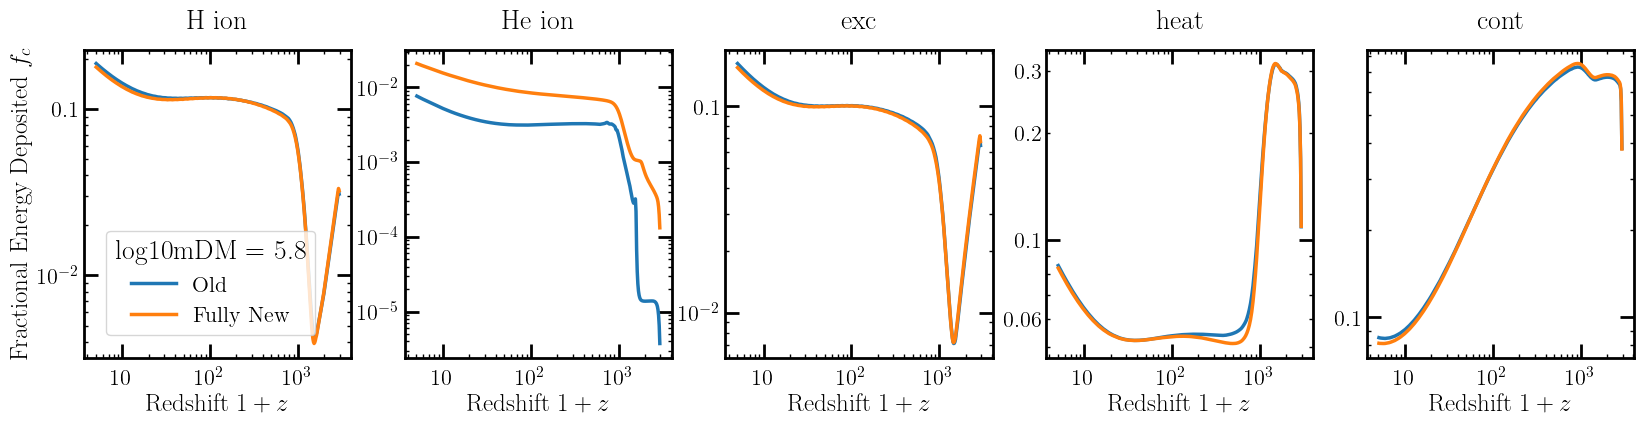

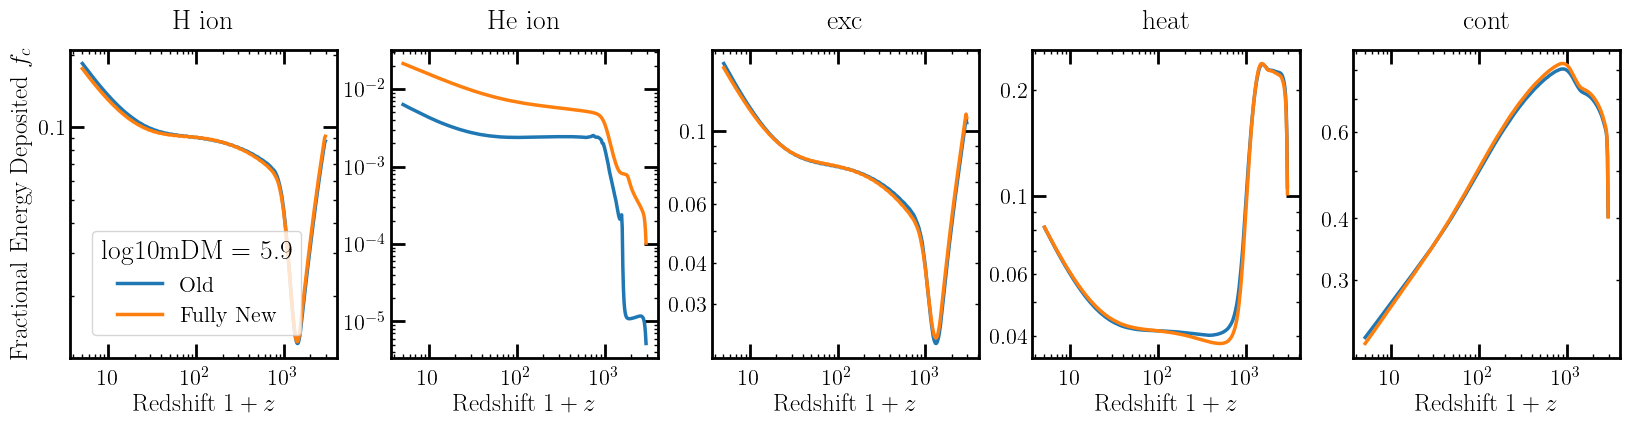

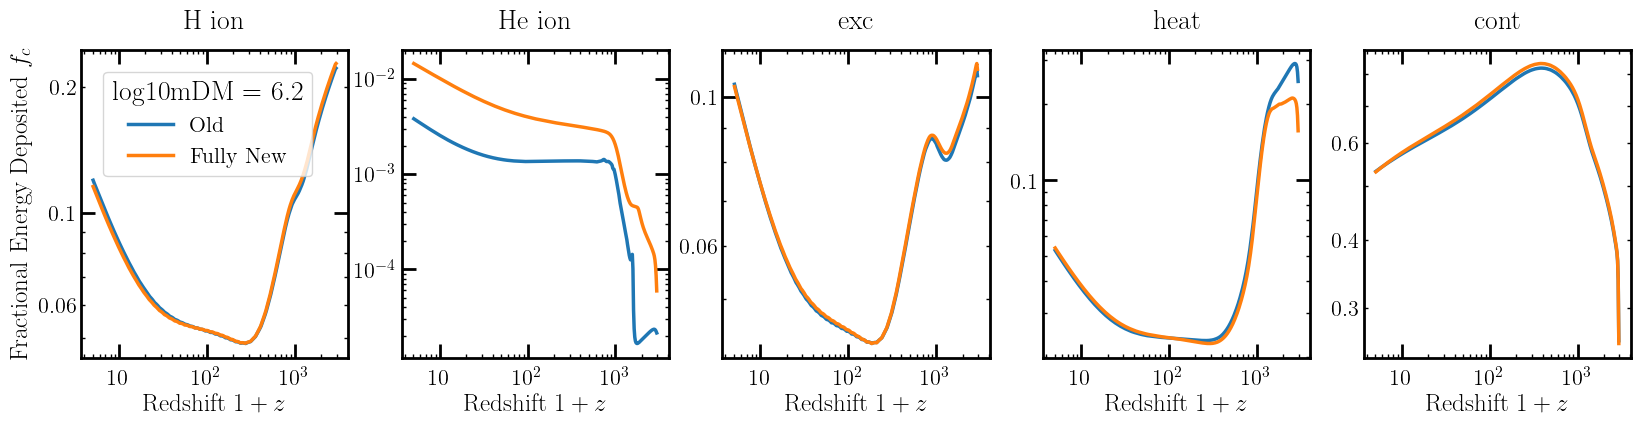

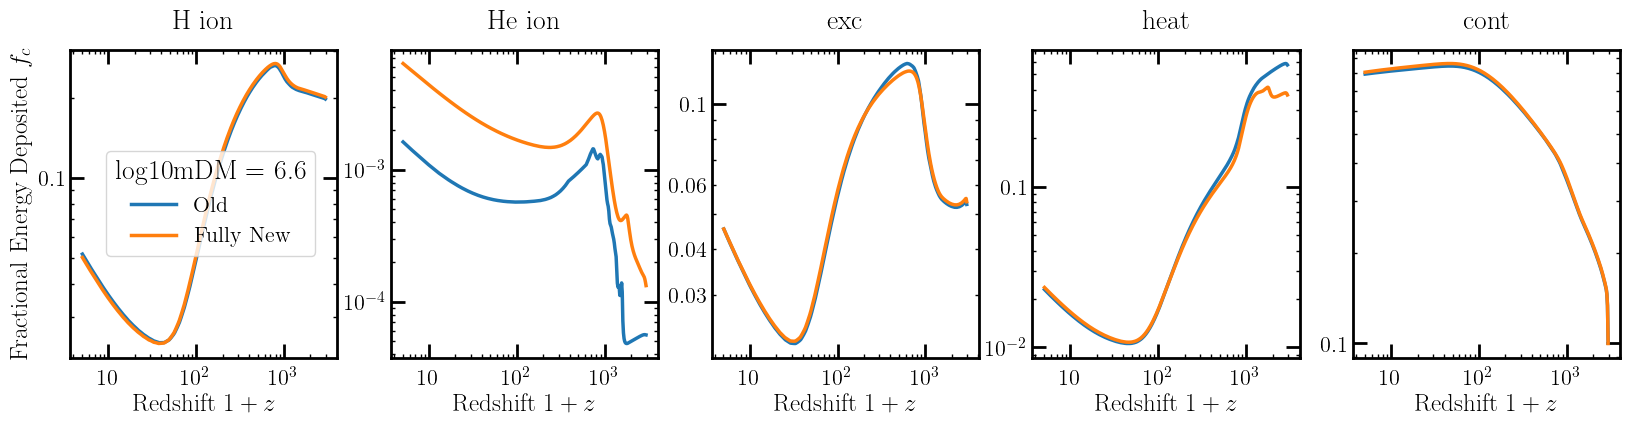

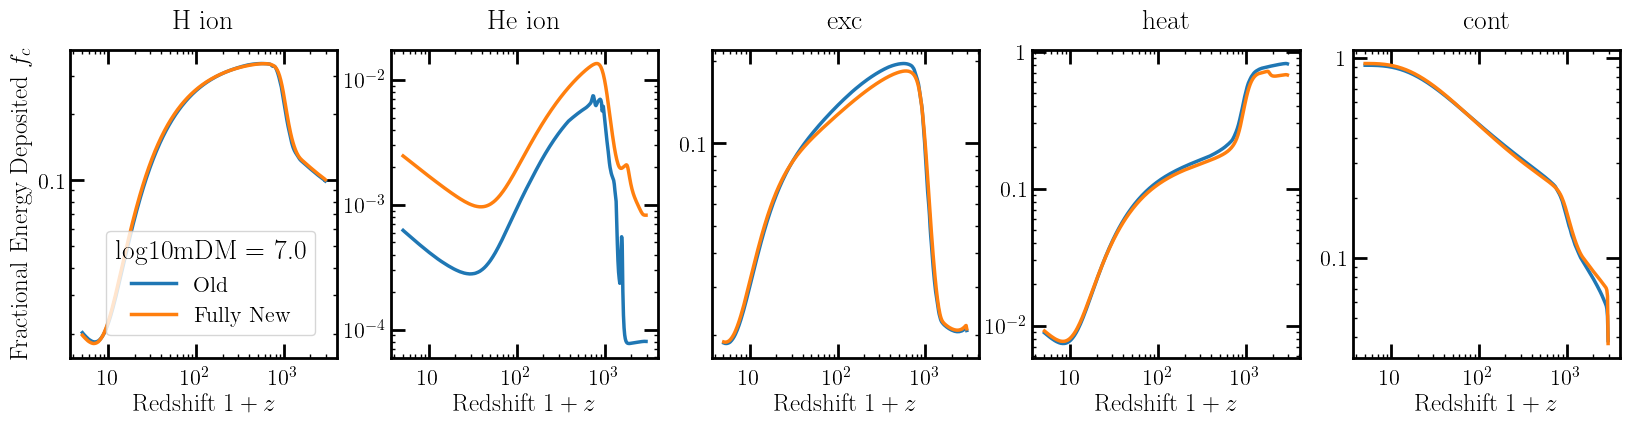

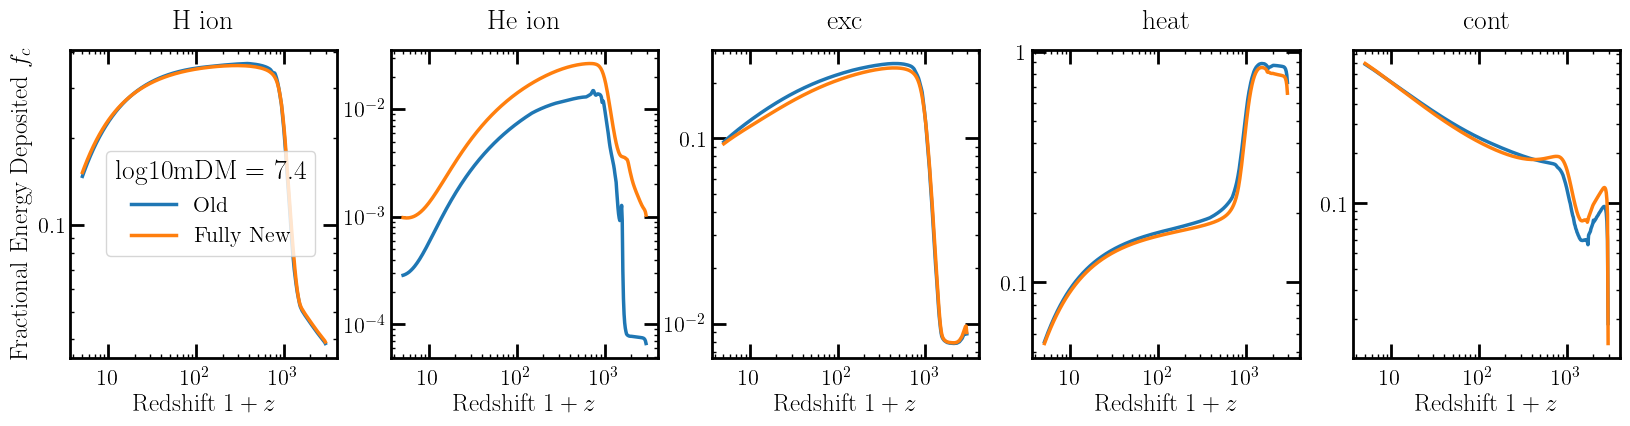

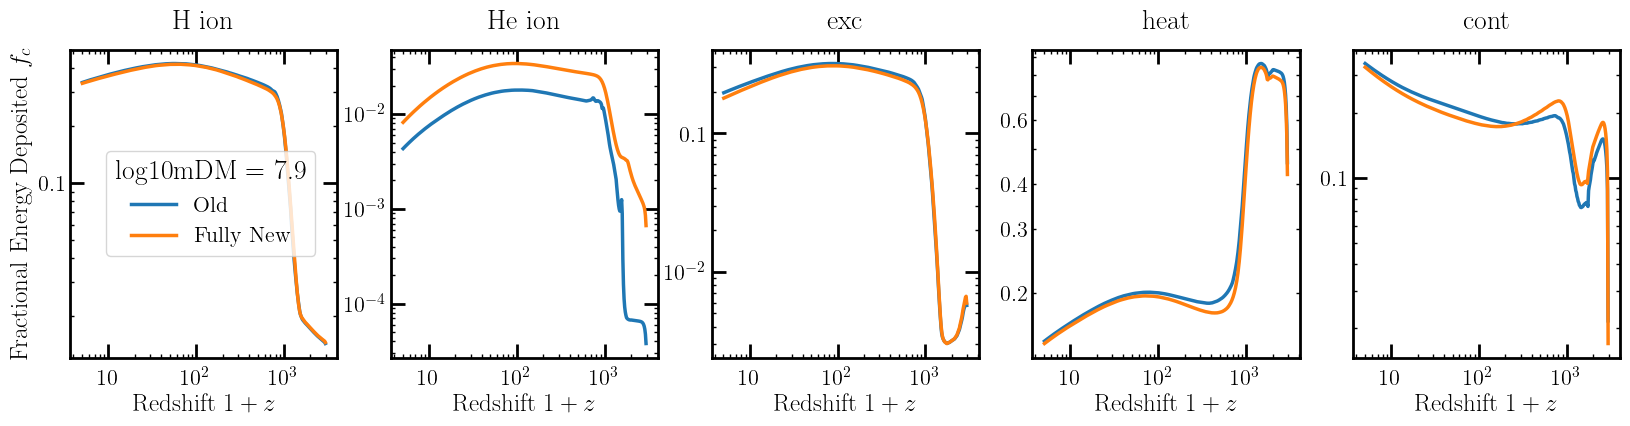

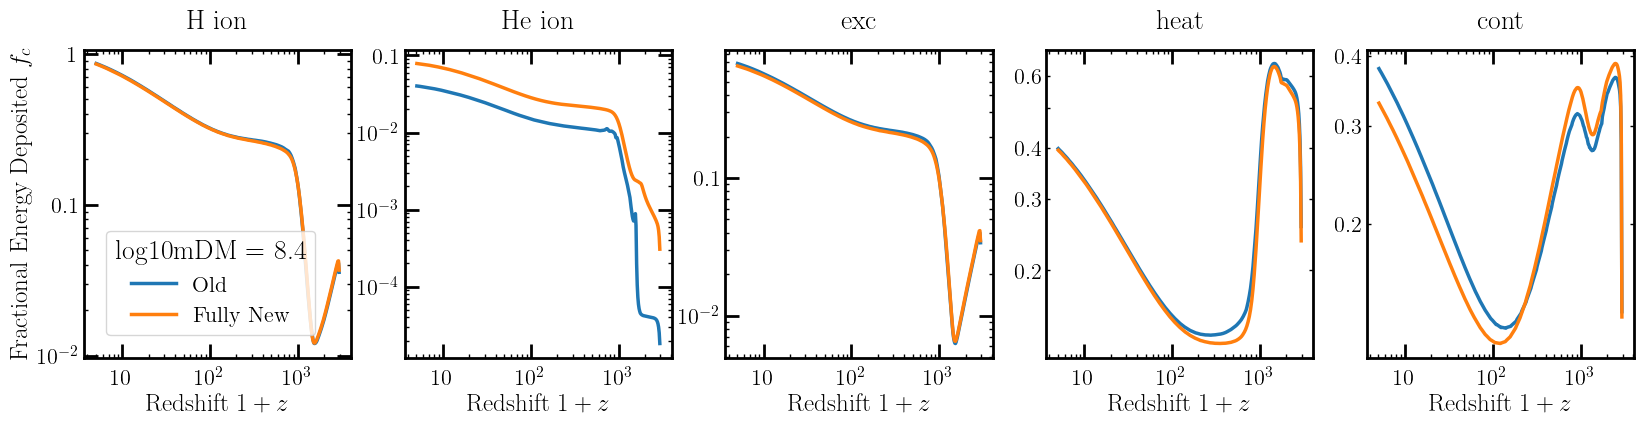

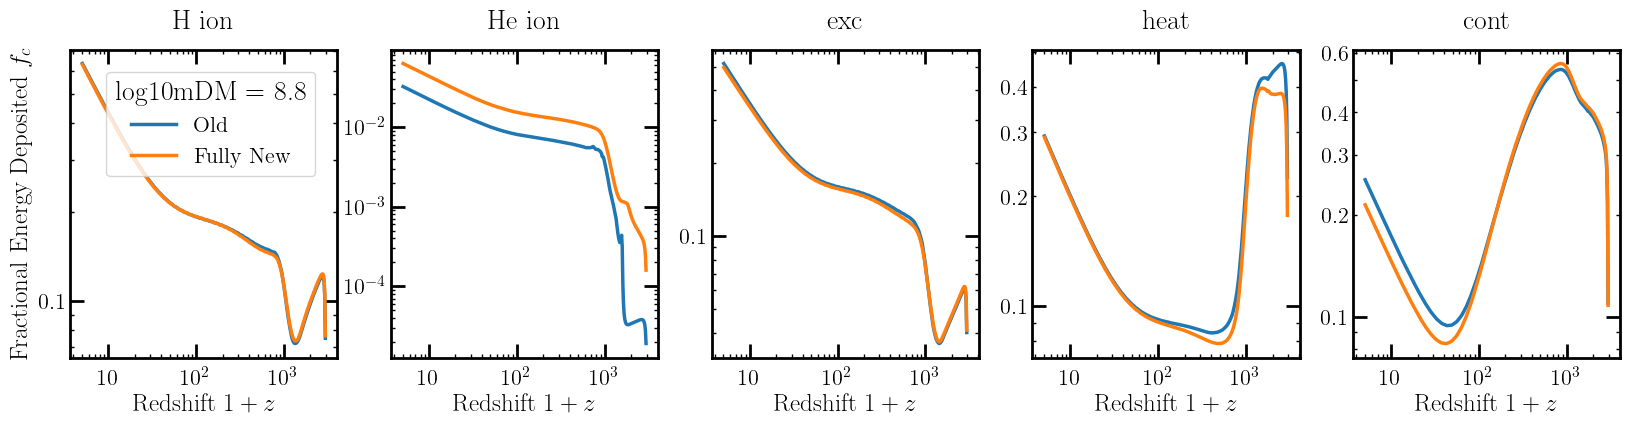

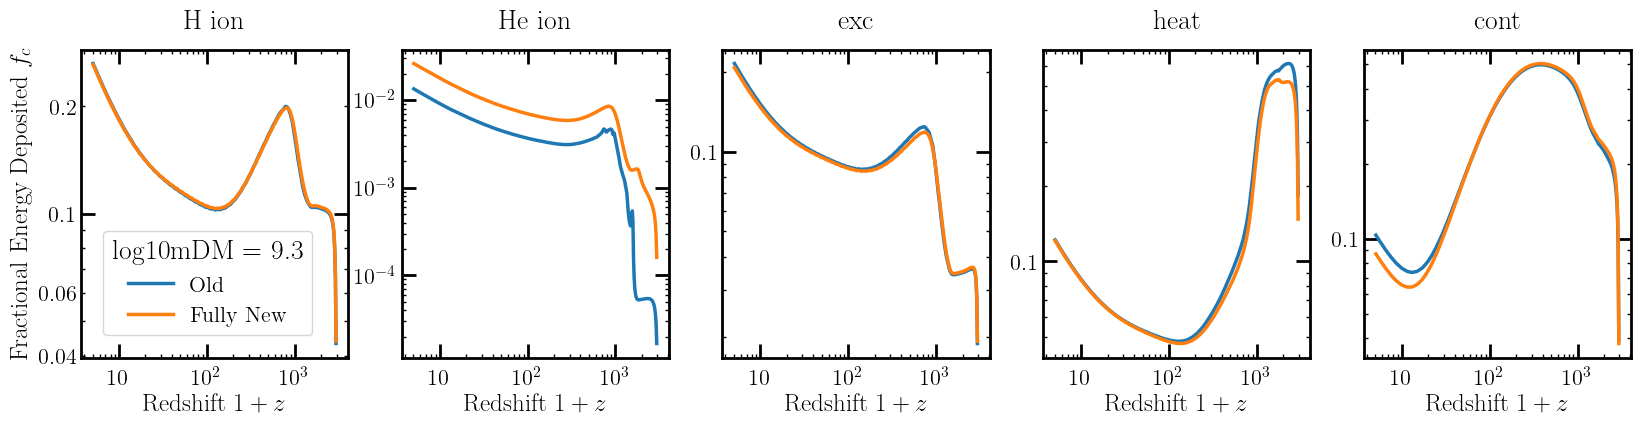

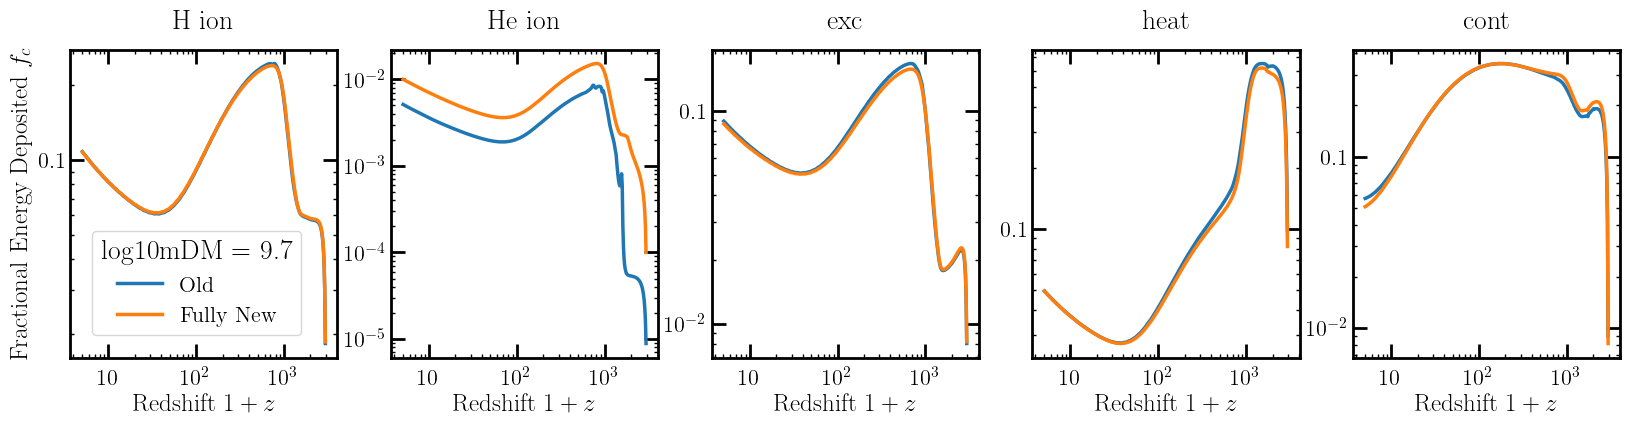

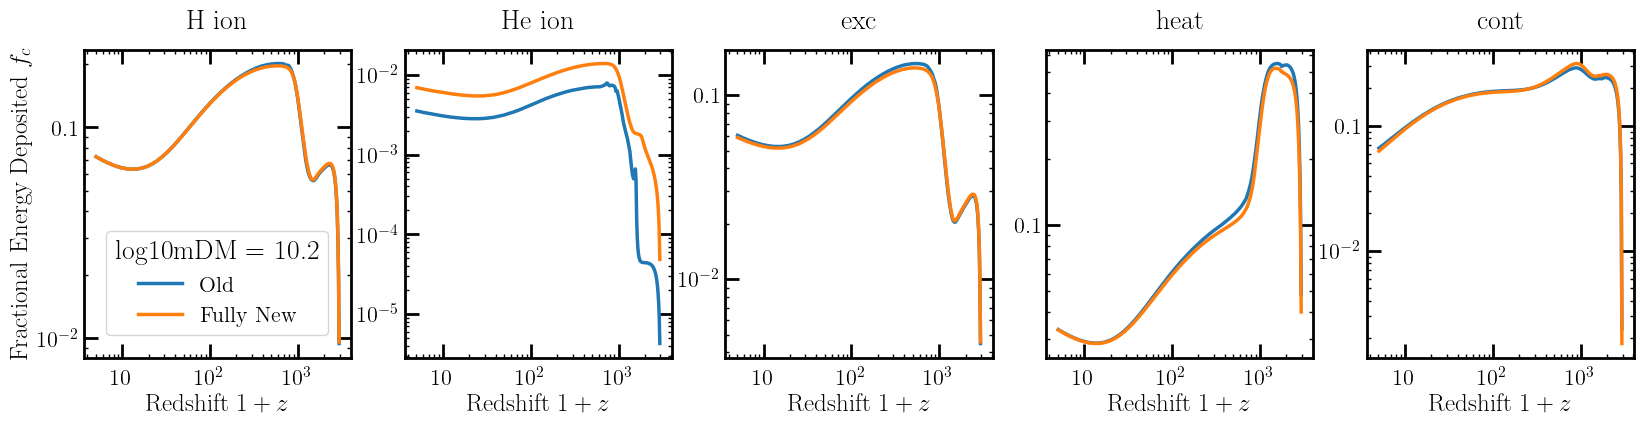

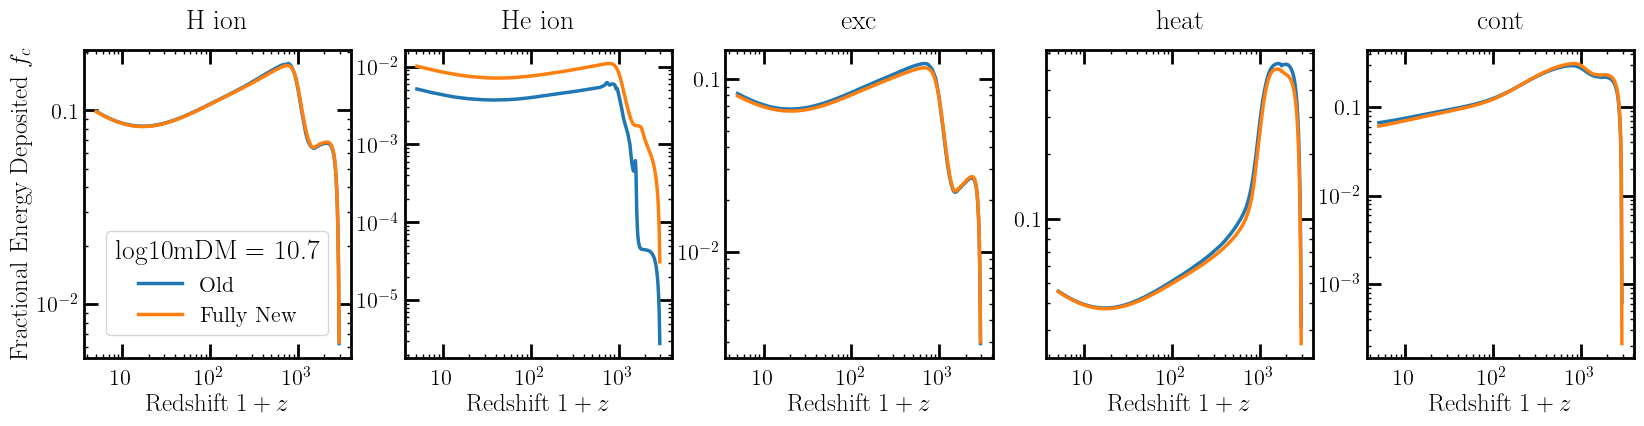

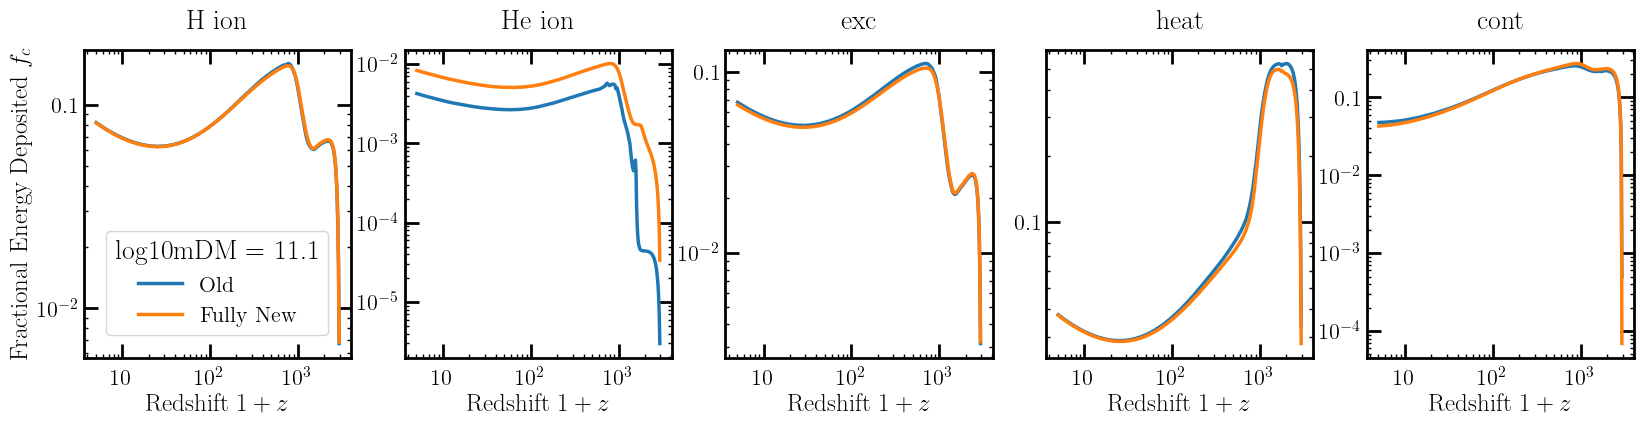

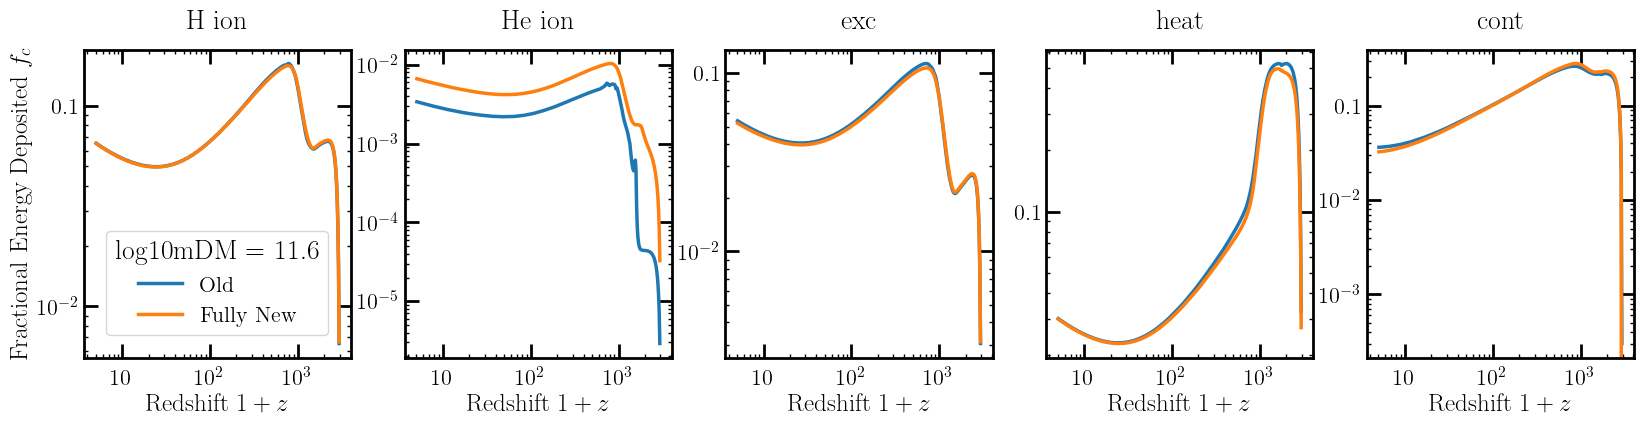

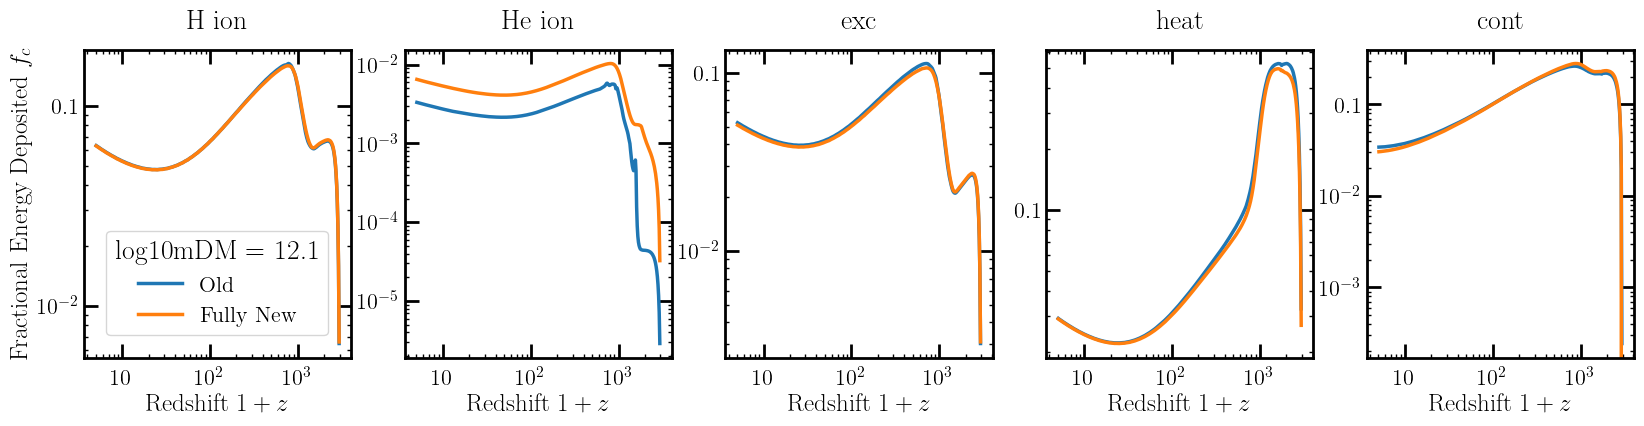

In [10]:
rs_tmp = np.exp(np.arange(np.log(3e3), np.log(5), -.001*16))
for m_ind in np.arange(0,38,2):

    mDM = mDM_list[m_ind]

    fig, axarr = plt.subplots(1,5, figsize=(4*5,4))

    ch_std = ['H ion', 'He ion', 'exc', 'heat', 'cont']
    ch_run = ['H ion', 'He ion', 'Lya', 'heat', 'cont']

    for i in np.arange(5):
        axarr[i].loglog()
        axarr[i].set_xlabel(r'Redshift $1+z$')
        axarr[i].set_title(ch_std[i], fontsize=20)

        axarr[i].plot(
            rs_tmp[1:], phys.f_std(mDM, rs_tmp[1:], pri, DM_process, channel=ch_std[i]), label='Old'
        )

        axarr[i].plot(rs_tmp[1:], fs_data[m_ind][ch_run[i]][1:], label='Fully New')

    axarr[0].set_ylabel(r'Fractional Energy Deposited $f_c$')
    axarr[0].legend(title='log10mDM = '+"{:.1f}".format(np.log10(mDM)))

In [11]:
def get_fdiff(pri, DM_process, channel, ax):
    
    ind = {'H ion' : 0, 'He ion' : 1, 'Lya' : 2, 'heat' : 3, 'cont' : 4}[channel]
    ch_std = ['H ion', 'He ion', 'exc', 'heat', 'cont']
    ch_run = ['H ion', 'He ion', 'Lya', 'heat', 'cont']
    
    rs_tmp = np.exp(np.arange(np.log(3e3), np.log(5), -.001*16))
    eng = 10**log10eng
    
    f_NEW = np.ones((eng.size, rs_tmp.size-2))*1e-6
    f_OLD = np.ones((eng.size, rs_tmp.size-2))*1e-6
    
    for m_ind in np.arange(eng.size-1):
        f_NEW[m_ind] = fs_data[m_ind][ch_run[ind]][2:]
        f_OLD[m_ind] = phys.f_std(mDM_list[m_ind], rs_tmp[2:], 
                              pri, DM_process, channel=ch_std[ind])
        
        if m_ind == 0:
            print(sum(f_OLD[m_ind]))
        
#             print(max(f_OLD[m_ind]/f_NEW[m_ind]-1))
    
    if ind < 2:
        label = {'H ion' : 'H_{ion}', 'He ion' : 'He_{ion}'}[channel]
        
    else:
        label = channel
        
    title = r'\bf{$f_{'+label+'}$}'

    ax.loglog()
    
    levels=[0,.01,.05,.1,.2,.5,1.]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_NEW)
    diffs = np.abs(
        f_NEW - f_OLD
    )/f_NEW
    
    cs = ax.contourf(eng, rs_tmp[2:], np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r)
    
    if channel == 'cont':
        cbar = plt.colorbar(cs, ticks=levels)
    
    ax.set_title(title)
    ax.set_ylabel(r'Redshift ($1+z$)')
    ax.set_xlabel(r'Kinetic Energy [eV]')

38.29185658674304
1.4328534714854684
33.096101127702845
39.78967676346295
129.36679327010722


<Figure size 620x620 with 0 Axes>

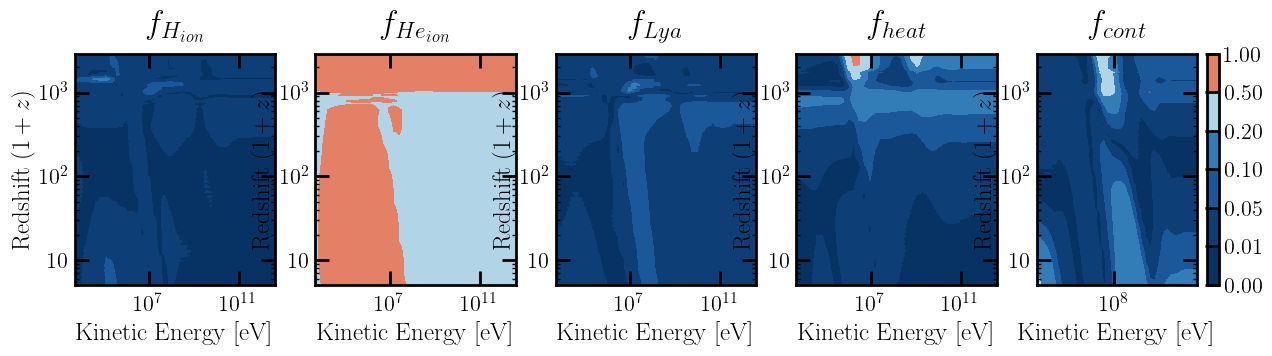

In [13]:
plt.figure()
_, axarr = plt.subplots(1,5, figsize = (15, 15/5.))
ax = plt.gca()

for i, chan in enumerate(['H ion', 'He ion', 'Lya', 'heat', 'cont']):
    get_fdiff(pri, DM_process, chan, axarr[i])

# 2. $f_c(z)$ vs. MEDEA

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [14]:
# Load data.
binning = load_data('binning')
photeng = binning['phot']
eleceng = binning['elec']

dep_tf_data = load_data('dep_tf')

ics_tf_data = load_data('ics_tf')

ics_thomson_ref_tf  = ics_tf_data['thomson']
ics_rel_ref_tf      = ics_tf_data['rel']
engloss_ref_tf      = ics_tf_data['engloss']

spec_2s1s = main.generate_spec_2s1s(photeng)

#MEDEA
H_states = ['2s', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p']

(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs,
    ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [15]:
#Probs that a given state decays ultimately to '2p'
Ps = {'2p': 1.0000, '2s': 0.0, '3p': 0.0,
      '4p': 0.2609,'5p': 0.3078,'6p': 0.3259,
      '7p': 0.3353,'8p': 0.3410,'9p': 0.3448,'10p': 0.3476}

#ionization levels probed by MEDEA
xes = np.array([
    1e-4, 1.5e-4, 2e-4, 3e-4, 5e-4,
    1e-3, 1.5e-3, 2e-3, 3e-3, 5e-3,
    1e-2, 1.5e-2, 2e-2, 3e-2, 5e-2,
    1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1,
    7e-1, 8e-1, 9e-1, 9.5e-1, 9.9e-1, 
    1.0
])

channels = ['heat', 'exc', 'H ion', 'He ion', 'cont']
fs = {chan: np.zeros((xes.size, eleceng.size)) for chan in channels}

In [16]:
rs=1
for i,xHII in enumerate(tqdm(xes)):
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_arr
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=xHII * phys.chi,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            spec_2s1s = spec_2s1s, H_states=H_states
        )

    fs['heat'][i]   = deposited_heat_arr/eleceng
    fs['H ion'][i]  = deposited_ion_arr['H']/eleceng
    fs['He ion'][i] = deposited_ion_arr['He']/eleceng
    
    fs['exc'][i]  = np.sum([
        deposited_exc_arr[species]*Ps[species] * phys.lya_eng/phys.H_exc_eng(species)
    for species in Ps], axis=0)/eleceng

    fs['cont'][i] = np.sum([
        deposited_exc_arr[species]*(1-Ps[species]) * (1+1-phys.lya_eng/phys.H_exc_eng(species))
    for species in Ps], axis=0)/eleceng + (
    deposited_ICS_arr/eleceng)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_96093/633125279.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,xHII in enumerate(tqdm(xes)):


  0%|          | 0/26 [00:00<?, ?it/s]

In [17]:
our_fs = np.array([fs[chan] for chan in channels])
our_fs = our_fs.swapaxes(0,2)
our_fs = our_fs.swapaxes(0,1)

MEDEA_interp = lowE_elec.make_interpolator()
DH_interp = utils.Interpolator2D(
    xes, 'xes', eleceng, 'engs', our_fs, logInterp=True
)

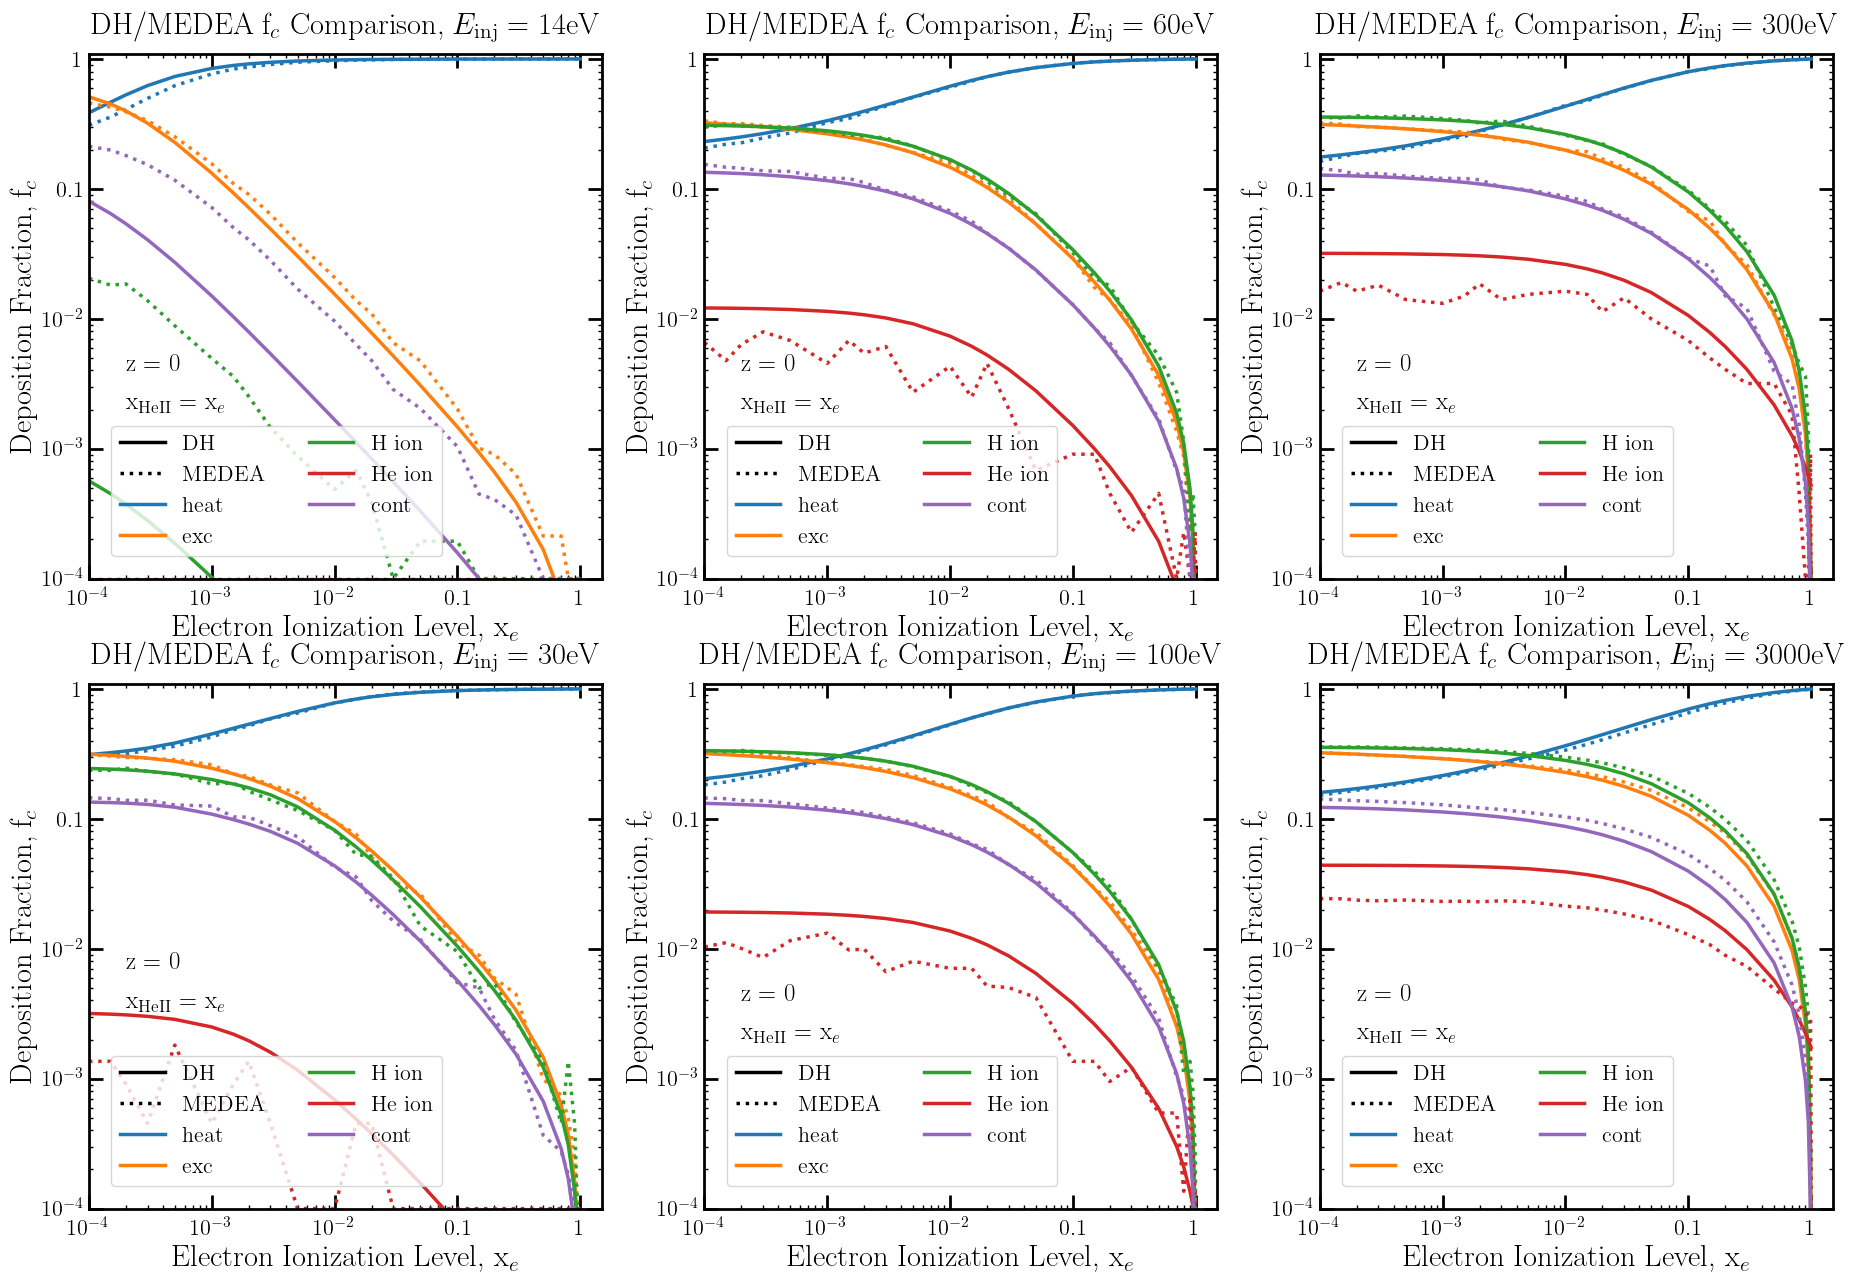

In [18]:
initEs = np.array([14, 30, 60, 100, 300, 3000])
fig, axarr = plt.subplots(2, int(initEs.size/2), figsize=(7.5*initEs.size/2,2*7.5))
for i, initE in enumerate(initEs):
    j = int(i%2)
    k = int(np.floor(i/2))
    DH_data = DH_interp.get_vals(xes,initE)
    MEDEA_data = MEDEA_interp.get_vals(xes,initE)

    axarr[j][k].loglog()
    axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', label='DH')
    axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', linestyle=':', label='MEDEA')

    for j1 in np.arange(5):
        axarr[j][k].plot(xes, DH_data[:,j1], color='C'+str(j1), label=channels[j1])
        axarr[j][k].plot(xes, MEDEA_data[:,j1], color='C'+str(j1), linestyle=':')

    axarr[j][k].axis([1e-4, 1.5, 1e-4,1.1])
    axarr[j][k].set_title(r'DH/MEDEA f$_c$ Comparison, $E_{\mathrm{inj}} = '+str(initE)+'$eV', fontsize=22)
    axarr[j][k].set_xlabel(r'Electron Ionization Level, x$_e$', fontsize=22)
    axarr[j][k].set_ylabel(r'Deposition Fraction, f$_c$', fontsize=22)
    if i!=1:
        leg_y = 4e-3
    else:
        leg_y = 7e-3
    axarr[j][k].text(2e-4, leg_y, r'z = '+str(rs-1), fontsize = 18)
    axarr[j][k].text(2e-4, leg_y/2, r'x$_{\mathrm{HeII}}$ = x$_e$', fontsize = 18)
    axarr[j][k].legend(ncol=2, loc=3)
    
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/MEDEA_CrossCheck.pdf')

# 3. $f_c(z)$ vs. Acharya+Khatri

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [19]:
files = ['heat', 'ICS', 'He ion', 'H ion', 'H exc2', 'H exc3', 'He exc']
Acharya_f = {'04': {}, '0002': {}}
for num in ['04', '0002']:
    for f in files:
        Acharya_f[num][f] = []
        with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/Distortions/'
                  +'Acharya'+num+'/'+f+'.csv') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                Acharya_f[num][f].append([float(row[0]),float(row[1])])
        Acharya_f[num][f] = np.array(Acharya_f[num][f])
        Acharya_f[num][f] = interp1d(Acharya_f[num][f][:,0], Acharya_f[num][f][:,1],
                                    bounds_error=False, fill_value=(1e-10,1e-10))

In [20]:
eleceng, photeng = binning['elec'], binning['phot']
H_states  = ['2s', '2p', '3p']

spec_2s1s = main.generate_spec_2s1s(photeng)
(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs, ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

simple_ICS = True
DH_f = {'04': {}, '0002': {}}
for i, num in enumerate(['04', '0002']):
    if num == '04':
        xHII = 4e-2
        rs = 1001
    else:
        xHII = 2e-4
        rs=101
        
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=0,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            #loweng=eleceng[0], 
            spec_2s1s = spec_2s1s,
            simple_ICS=simple_ICS,
            check_conservation_eng=False,
            H_states=H_states
    )
    
    DH_f[num]['heat'] = deposited_heat_arr/eleceng
#     if simple_ICS:
    DH_f[num]['ICS'] = deposited_ICS_arr/eleceng #(np.dot(ics_sec_phot_tf.grid_vals, photeng)-0*deposited_ICS_arr)/eleceng
#     else:
#         DH_f[num]['ICS']= np.dot(ics_sec_phot_tf.grid_vals, photeng)/eleceng
    DH_f[num]['He ion'] = deposited_ion_arr['He']/eleceng
    DH_f[num]['H ion']  = deposited_ion_arr['H']/eleceng
    DH_f[num]['H exc2'] = (deposited_exc_arr['2s']+deposited_exc_arr['2p'])/eleceng
    DH_f[num]['H exc3'] = deposited_exc_arr['3p']/eleceng
    DH_f[num]['He exc'] = (deposited_exc_arr['HeI']+deposited_exc_arr['HeII'])/eleceng

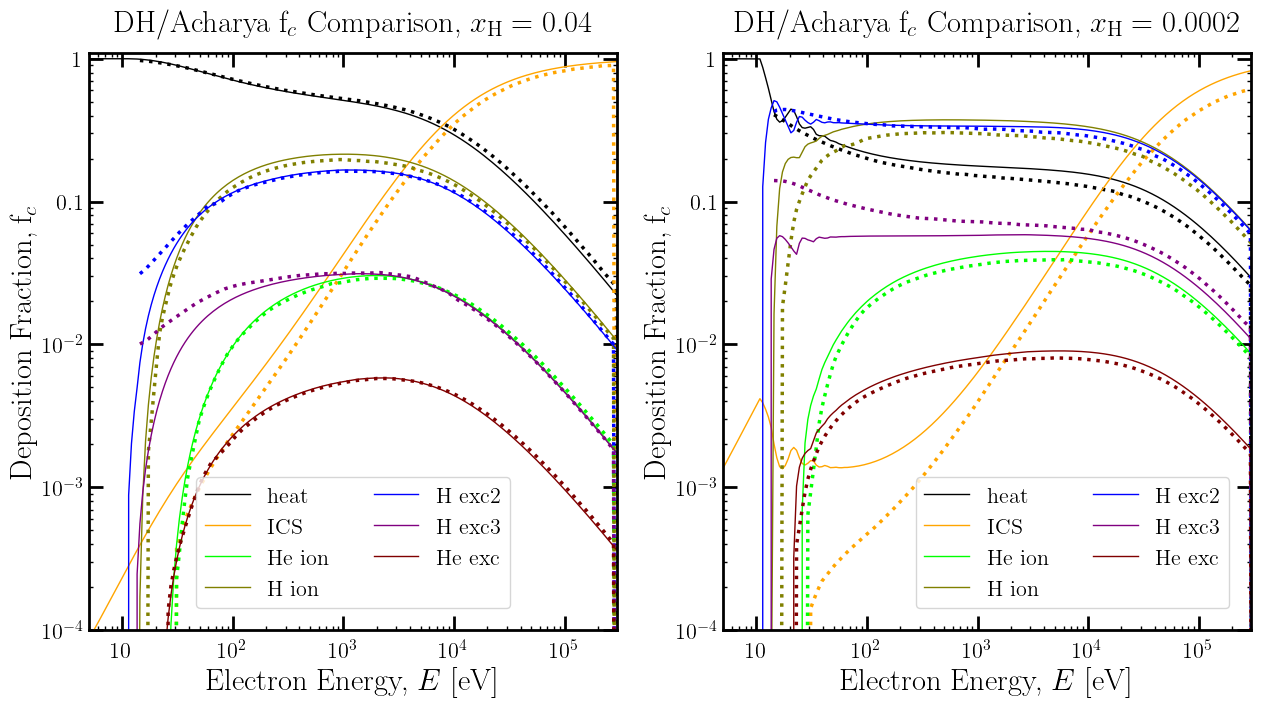

In [21]:
#!!! Remember how oscillations are related to excitation thresholds
#!!! Remember why ICS shoots up at 10eV in left plot
initEs = np.array([14, 30, 60, 100, 300, 3000])
fig, axarr = plt.subplots(1, 2, figsize=(15,7.5))
colors = {'heat':'k', 
              'ICS': 'orange', 
              'He ion': 'lime', 
              'H ion': 'olive', 
              'H exc2': 'blue', 
              'H exc3': 'purple', 
              'He exc': 'maroon'}
for i, num in enumerate(['04', '0002']):
    axarr[i].loglog()
    for f in files:
        ind = sum(eleceng<14)
        axarr[i].plot(eleceng[ind:], Acharya_f[num][f](eleceng[ind:]),
                      color=colors[f], linestyle=':')
        axarr[i].plot(eleceng, DH_f[num][f], 
                      color=colors[f], linestyle='solid', linewidth=1, label=f)

    axarr[i].axis([5, 3e5, 1e-4,1.1])
    axarr[i].set_title(r'DH/Acharya f$_c$ Comparison, $x_{\mathrm{H}} = 0.$'+str(num), fontsize=22)
    axarr[i].set_xlabel(r'Electron Energy, $E$ [eV]', fontsize=22)
    axarr[i].set_ylabel(r'Deposition Fraction, f$_c$', fontsize=22)
    axarr[i].legend(ncol=2)

# 4. $x_e(z)$ vs. Hyrec

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [59]:
# Download Hyrec plots
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/EMLA.csv') as csvfile:
    reader = csv.reader(csvfile)
    EMLA_data = []
    for row in reader:
        EMLA_data.append([float(r) for r in row])
        
    EMLA_data = np.array(EMLA_data)
    
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/Recfast.csv') as csvfile:
    reader = csv.reader(csvfile)
    Rec_data = []
    for row in reader:
        Rec_data.append([float(r) for r in row])
        
    Rec_data = np.array(Rec_data)

In [60]:
start_rs, end_rs = 3e3, 200

cf = 16  # coarsen_factor
dlnz = -.001 * cf
rs_vec = np.exp(np.arange(np.log(start_rs), np.log(end_rs), dlnz))

baseline = tla.get_history(rs_vec, fudge=1.0)
fudge_1_14 = tla.get_history(rs_vec, fudge=1.14)


# iterative method

MLA_data = pickle.load(open(
    '/Users/gregoryridgway/Desktop/Data/'+
    'MLA_rates_nmax100_nlogdlnz3.5_endrs5fudge1.125.dat', 'rb'
    # /Users/gregoryridgway/Desktop/Data/MLA_funcs_100.p  # full_run_endrs5.p
))

alpha_MLA = interp1d(MLA_data[0], MLA_data[1])
beta_func = interp1d(np.log(MLA_data[0]), np.log(MLA_data[2]))
def beta_MLA(rs):
    return np.exp(beta_func(np.log(rs)))

iterated = tla.get_history(
      rs_vec, high_rs=np.inf,
      recfast_TLA=False,
      alpha_MLA=alpha_MLA, beta_MLA=beta_MLA,
      mxstep=10000, rtol=1e-8
)

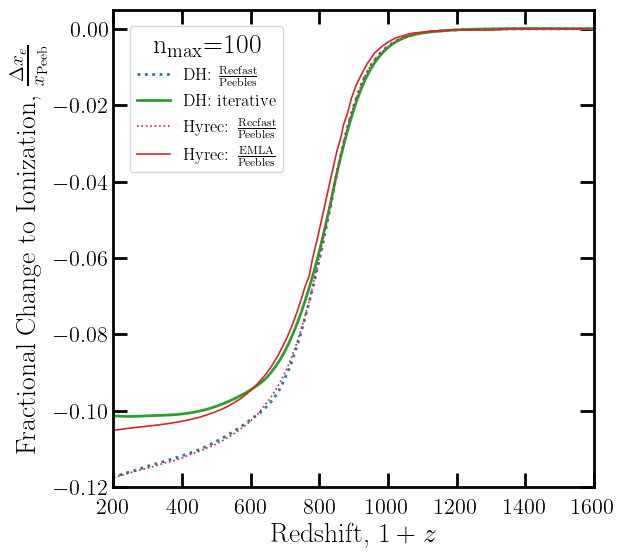

In [168]:
plt.figure()
plt.axis([200,1600, -.12,.005])

# DarkHistory plots
nmax=100
plt.plot(rs_vec, fudge_1_14[:,1]/baseline[:,1]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

plt.plot(rs_vec, iterated[:,1]/baseline[:,1]-1, 
         color='C2', linestyle='solid', linewidth = 2.0, 
         label=r'DH: iterative')

# goods = pickle.load(open('/Users/gregoryridgway/Desktop/Data/full_run_endrs5.p', 'rb'))
# res = tla.get_history(goods['rs'], fudge=1.0, rtol=1e-6)[:,1]
# plt.plot(goods['rs'], goods['x'][:,0]/res-1, 
#          color='C4', linestyle='solid', linewidth = 2.0, 
#          label=r'DH: Full')


# hyrec plots
lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')


# plot labels
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax), fontsize=12)

# 5. `distortion` vs. Jens+Sunyaev

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

- BB only, nmax = 10,20,30, no 2s
- BB only, with 2s
- BB + BF + 2s

In [100]:
# Dictionary containing different types of distortions
distortion_dict = {}

# Create 2s -> 1s spectrum
hplanck = phys.hbar * 2*np.pi
eng = np.exp(np.linspace(
    np.log(hplanck*1e8), np.log(phys.rydberg), 500))

spec_2s1s = spectools.discretize(eng, phys.dNdE_2s1s)

In [140]:
%autoreload
rs_vec = np.exp(np.arange(np.log(3.5e3), np.log(5e2), dlnz))

# Load old runs
load = False

if load:
    distortion_dict['100_2sBF'] = pickle.load(open(
        '/Users/gregoryridgway/Dropbox (MIT)/'+
        'DarkHistory_V2/data/distortion100.p','rb'))  # includes 2s and BF
    
else:

    for nmax in [10,20,30,100]:

        if nmax==100:
            include_2s1s, include_BF = True, True
        else:
            include_2s1s, include_BF = False, False


        key = str(nmax)
        if include_2s1s:
            key += '_2s'
        if include_BF:
            key += 'BF'

        if key not in distortion_dict:
            distortion_dict[key] = Spectrum(
                eng, np.zeros_like(eng), spec_type='N', rs=1)
        else:
            distortion_dict[key].N *= 0

        # Store individual components of the distortion
        delta_dists = Spectra(
            np.zeros((len(rs_vec), len(eng))), 
            eng=eng, spec_type='N', rs=rs_vec)

        # Build up the distortion one redshift at a time
        for i, rs in enumerate(tqdm(rs_vec)):

            dt = -dlnz/phys.hubble(rs)
            xHI = phys.xHI_std(rs)
            Tm = phys.Tm_std(rs)

            alpha_MLA, beta_MLA, transition_spec = atomic.get_distortion_and_ionization(
                rs, dt, xHI, Tm, nmax, spec_2s1s.eng,
                Delta_f=None, cross_check=False,
                include_2s1s=include_2s1s, include_BF=include_BF, spec_2s1s=spec_2s1s,
                fexc_switch=False, deposited_exc_arr=None, elec_spec=None,
                distortion=None, H_states=None, rate_func_eng=None, A_1snp=None
            )

            delta_dists._grid_vals[i] = transition_spec.N
            transition_spec.redshift(1)
            distortion_dict[key] += transition_spec.N

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_96093/3050258613.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, rs in enumerate(tqdm(rs_vec)):


  0%|          | 0/122 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


  0%|          | 0/122 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [120]:
def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')
BB_BF_jens = download_plot('BB_plus_BF_dist')

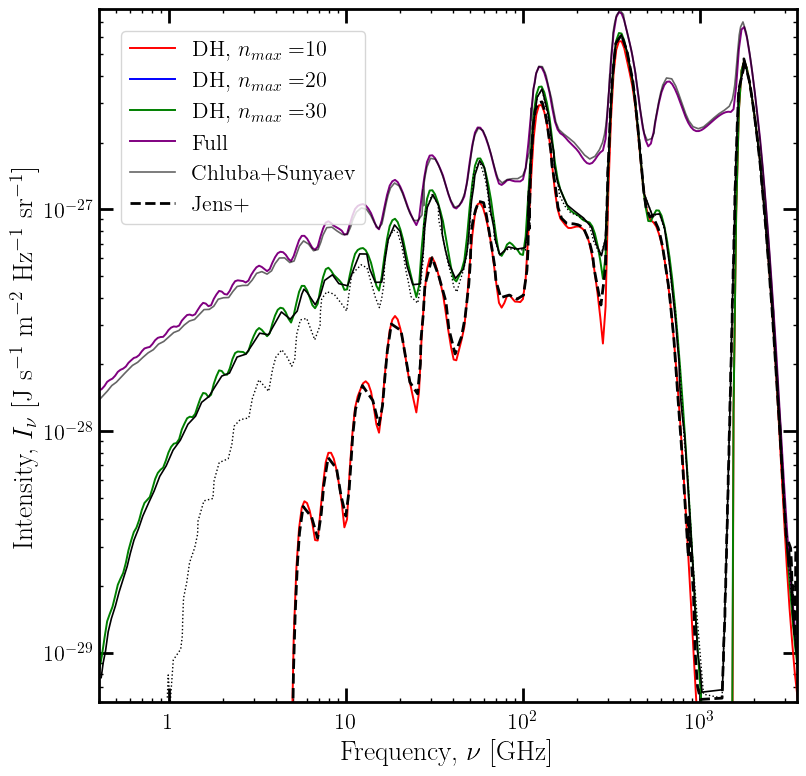

In [141]:
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(9, 9))
plt.loglog()
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])

# DH generated data
ns = ['10','20','30', '100_2sBF']
colors = ['red', 'blue', 'green', 'purple']
labels = ['DH, $n_{max}=$'+nmax if nmax != '100_2sBF' else 'Full' for nmax in ns]

for i,nmax in enumerate(ns):
    plt.plot(nu/1e9, convert * distortion_dict[nmax].dNdE,
             color=colors[i], linewidth=1.4, label=labels[i])


# Data from Jens Chluba et al's papers
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
plt.plot(n10_data[:,0], n10_data[:,1], color='k',
         linewidth=2.0, linestyle='--', label='Jens+')
plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

plt.legend(loc=2)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
if cf>1 and (not load):
    print('WARNING: There are extra errors from coarsening')

# 6. Misc

### Hirata_2005

In [ ]:
(
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=0,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            #loweng=eleceng[0], 
            spec_2s1s = spec_2s1s,
            simple_ICS=simple_ICS,
            check_conservation_eng=False,
            H_states=H_states
    )

In [ ]:
#Probs that a given state decays ultimately to '2p'
Ps = {'2p': 1.0000, '2s': 0.0, '3p': 0.0,
      '4p': 0.2609,'5p': 0.3078,'6p': 0.3259,
      '7p': 0.3353,'8p': 0.3410,'9p': 0.3448,'10p': 0.3476}

### Testing the TLA assumptions (getting back detailed balance, then Peebles C)

In [203]:
alphas, betas = {}, {}

In [227]:
%autoreload
rs_vec = np.exp(np.arange(np.log(1.555e3), np.log(5), -dlnz))
rs_vec = np.exp(np.linspace(np.log(3e3), np.log(5), 150))

nmax = 100
key = str(nmax)

# if key not in alphas:
alphas[key], betas[key] = np.zeros_like(rs_vec), np.zeros_like(rs_vec)

# Build up the distortion one redshift at a time
for i, rs in enumerate(tqdm(rs_vec)):

    dt = dlnz/phys.hubble(rs)
    xHI = phys.xHI_std(rs)
    Tm = phys.Tm_std(rs)

    alphas[key][i], betas[key][i], transition_spec = atomic.get_distortion_and_ionization(
        rs, dt, xHI, Tm, nmax, spec_2s1s,
        Delta_f=None, cross_check=False,
        include_2s1s=include_2s1s, include_BF=include_BF,
        fexc_switch=False, deposited_exc_arr=None, elec_spec=None,
        distortion=None, H_states=None, rate_func_eng=None, A_1snp=None
    )

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_7059/1734762317.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, rs in enumerate(tqdm(rs_vec)):


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:493: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:497: RuntimeWarning: divide by zero encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:523: RuntimeWarning: divide by zero encountered in double_scalars
  b[nl] /= tot_rate


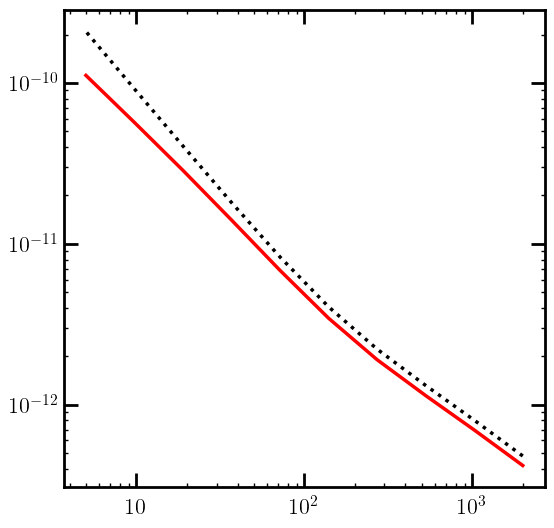

In [228]:
plt.figure()
plt.loglog()

plt.plot(rs_vec, alphas[key+'stim'], color='red')
# plt.plot(rs_vec, betas, color='red', linestyle=':')

plt.plot(rs_vec, phys.alpha_recomb(phys.Tm_std(rs_vec), 'HI'),
         color='k', linestyle=':')
# plt.plot(rs_vec, phys.beta_ion(phys.Tm_std(rs_vec), 'HI'), color='k', linestyle=':')

(1e-07, 0.01)

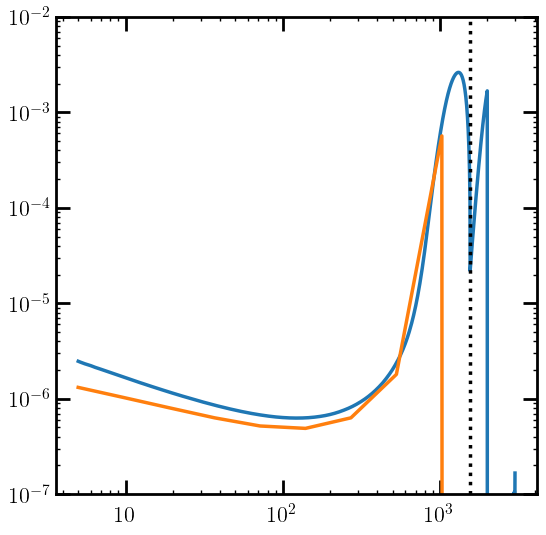

In [242]:
from scipy.interpolate import interp1d

plt.figure()
plt.loglog()

xHII_vec = phys.xHII_std(rs_vec)
xHI_vec = phys.xHI_std(rs_vec)
nH_vec = phys.nH*rs_vec**3
Tm_vec = phys.Tm_std(rs_vec)

# stuff = phys.alpha_recomb(
#     Tm_vec, 'HI') * xHII_vec**2 * nH_vec - \
#     4 * phys.beta_ion(Tm_vec, 'HI') * xHI_vec * np.exp(-phys.lya_eng/phys.TCMB(rs_vec))
    
# stuff *= -phys.peebles_C(xHII_vec, rs_vec)

# plt.plot(rs_vec, phys.dtdz(rs) * stuff)

rs_plot = np.exp(np.arange(np.log(3e3), np.log(5), -.001))
plt.plot(rs_plot, phys.xdot(phys.xHII_std(rs_plot), rs_plot))

stuff = alphas[key] * xHII_vec**2 * nH_vec - betas[key]
stuff *= -phys.dtdz(rs_vec)
# stuff = interp1d(rs_vec, stuff, 'linear')
# mask = rs_plot<rs_vec[0]
plt.plot(rs_vec, stuff)
plt.axvline(1.555e3, linestyle=':', color='k')

plt.ylim([1e-7,1e-2])

# plt.plot(rs_vec[:-1], np.diff(xHII_vec)/np.diff(rs_vec))